In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

데이터 생성 및 데이터 나누기  
**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

In [2]:
# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

데이터 시각화  
  
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')    
여기서 c는 그라데이션을 적용할 공간, cmap은 저장되어 있던 그라데이션 세트  

ax1.view_init(40, -60)  
보는 축을 변환한다.  

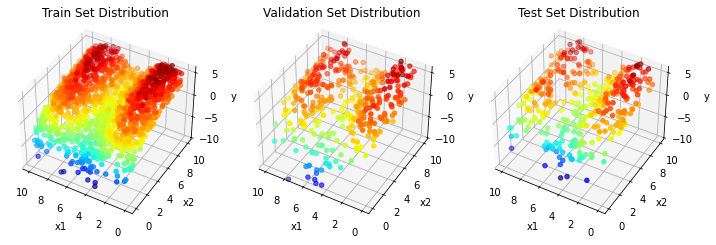

In [15]:
# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

데이터를 Linear Model과 MLP 모델 두개의 모델로 학습을 진행할 것이다.

**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

Linear모델과 MLP모델의 차이는 깊이의 차이라고 보면 될 것 같다.  
Linear은 1층이고, MLP는 하나의 히든 레이어를 포함한다  
여기서 MLP는 히든 레이어로 200개의 퍼셉트론을 지닌다.

---

모델을 생성한다.

In [18]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)
        ## CNN에서는 바이어스를 쓰지 않을수도 있음
    
    def forward(self, x):
        return self.linear(x)
    
    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
#lm = LinearModel()
#print(lm.linear.weight)
#print(lm.linear.bias)

파이토치의 nn아래에 다양한 Loss function이 이미 구현되어 있음  
ex) MSE, Cross-Entropy, KL-Divergence  
다음 링크에서 확인가능:[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)

In [20]:
reg_loss = nn.MSELoss()  
#test_pred_y = torch.Tensor([0,0,0,0])  
#test_true_y = torch.Tensor([0,1,0,1])  
#print(reg_loss(test_pred_y, test_true_y))  
#print(reg_loss(test_true_y, test_true_y))  

tensor(0.5000)
tensor(0.)


---

### 4. Train & Evaluation
loss.backward(): 알아서 loss를 계산, 각 파라미터에 대한 loss의 편미분을 계산  
optimizer.step(): 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트  
이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교  
그리고 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산, 여기서 Metric으로는 mean absolute error(MAE)를
활용
$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

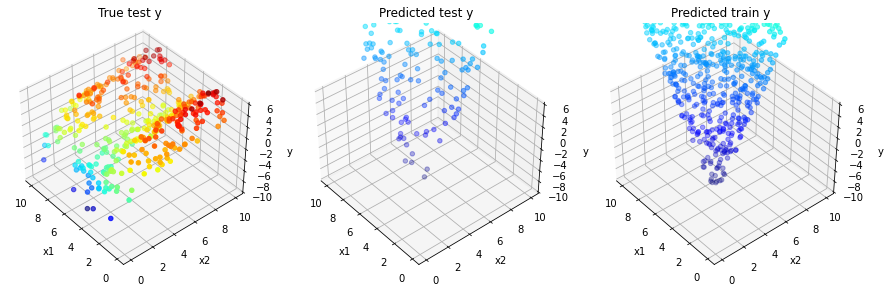

0 tensor(758.8451, grad_fn=<MseLossBackward0>)


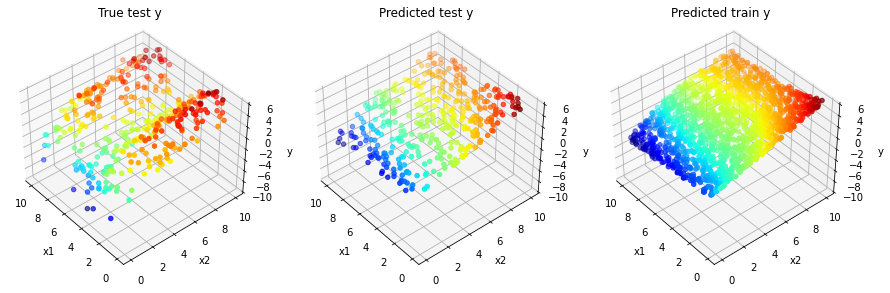

200 tensor(3.4426, grad_fn=<MseLossBackward0>)


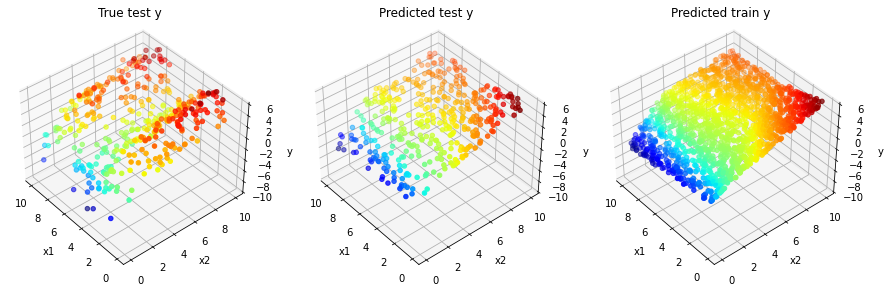

400 tensor(2.8170, grad_fn=<MseLossBackward0>)


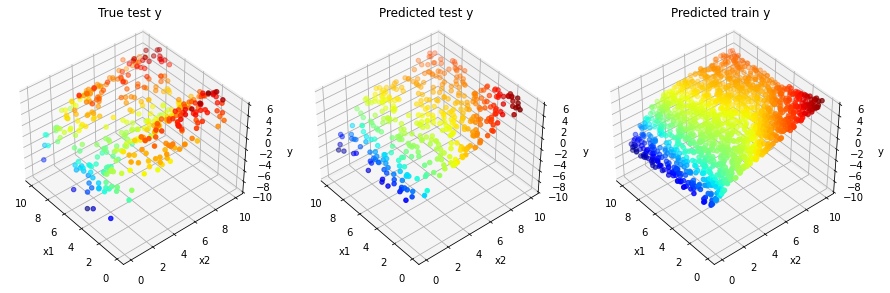

600 tensor(2.6033, grad_fn=<MseLossBackward0>)


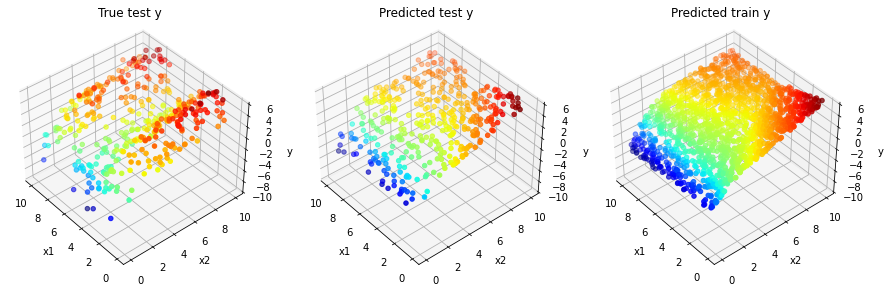

800 tensor(2.4540, grad_fn=<MseLossBackward0>)


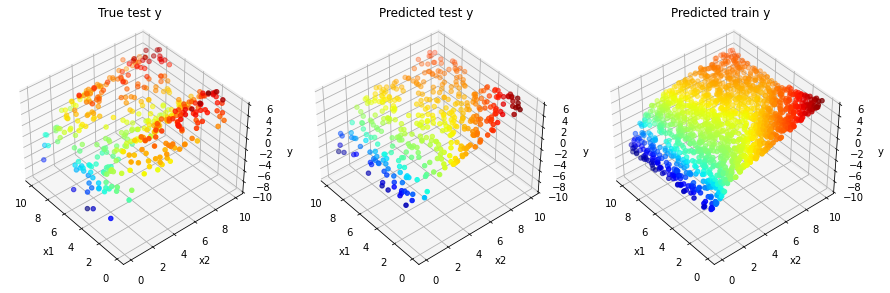

1000 tensor(2.3499, grad_fn=<MseLossBackward0>)


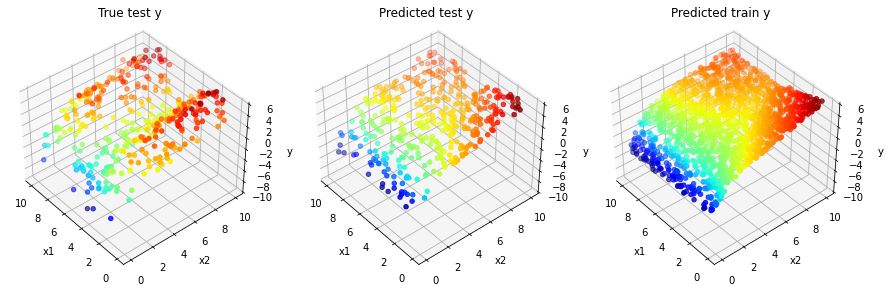

1200 tensor(2.2500, grad_fn=<MseLossBackward0>)


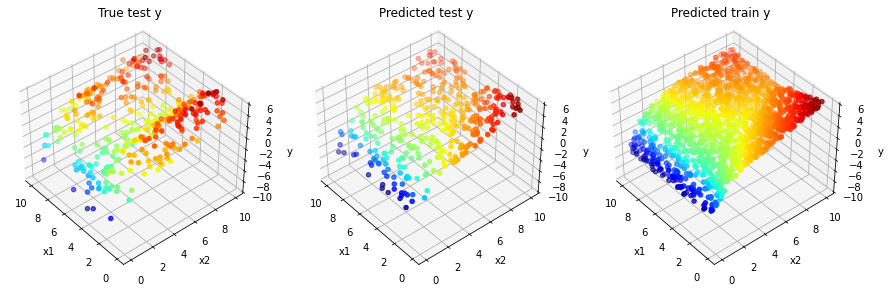

1400 tensor(2.1740, grad_fn=<MseLossBackward0>)


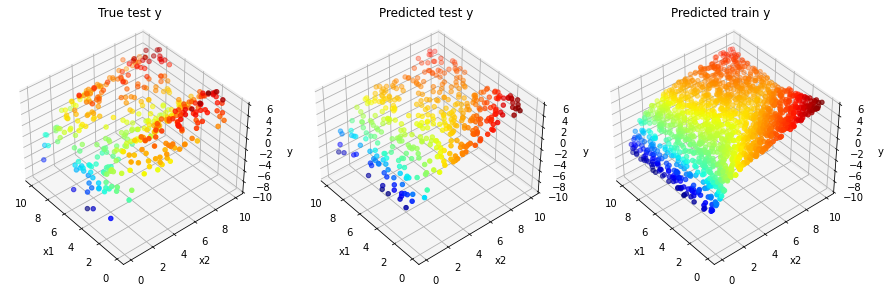

1600 tensor(2.0910, grad_fn=<MseLossBackward0>)


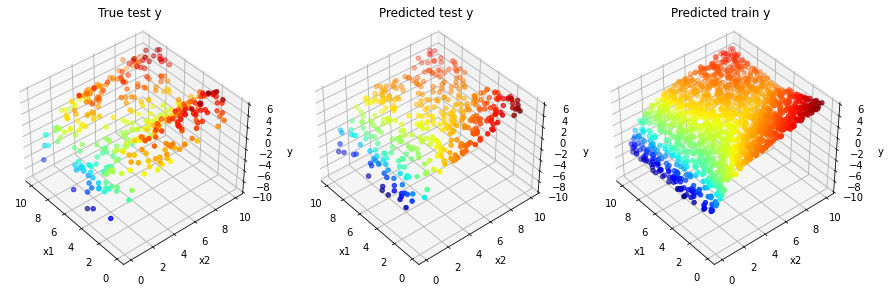

1800 tensor(2.0192, grad_fn=<MseLossBackward0>)


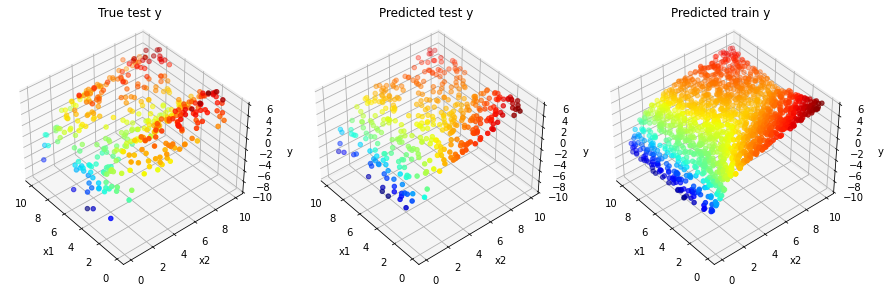

2000 tensor(1.9517, grad_fn=<MseLossBackward0>)


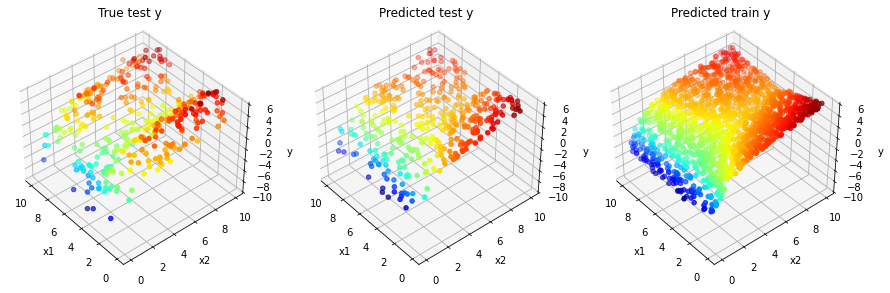

2200 tensor(1.8998, grad_fn=<MseLossBackward0>)


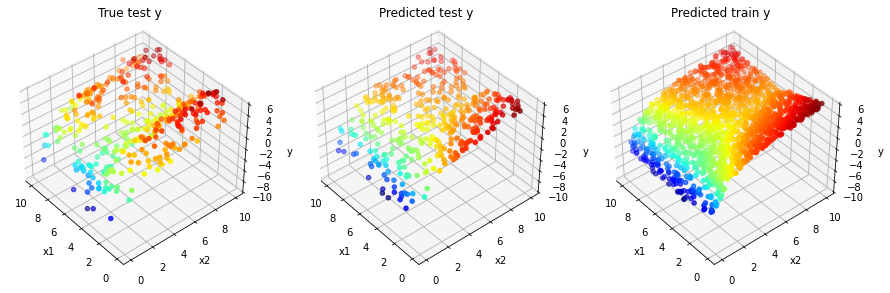

2400 tensor(1.8568, grad_fn=<MseLossBackward0>)


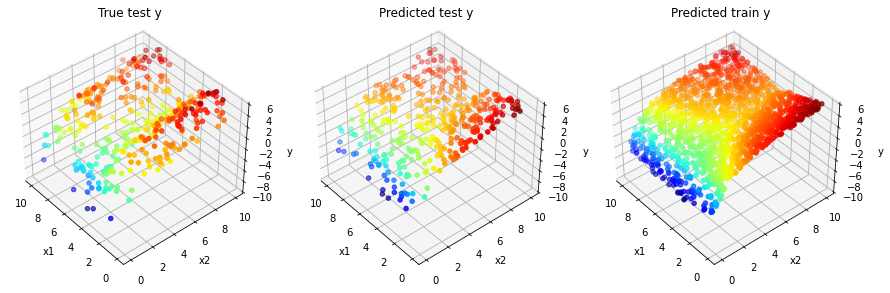

2600 tensor(1.8194, grad_fn=<MseLossBackward0>)


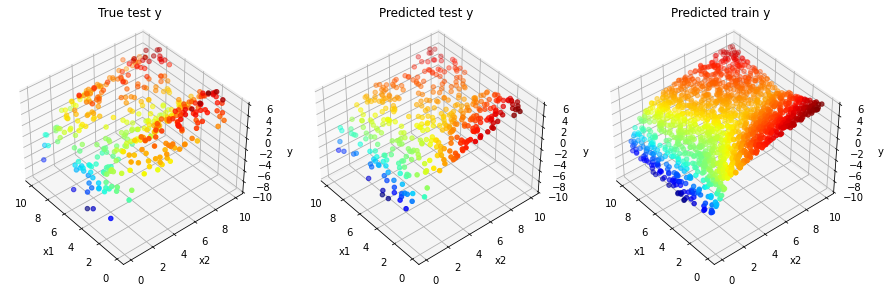

2800 tensor(1.7830, grad_fn=<MseLossBackward0>)


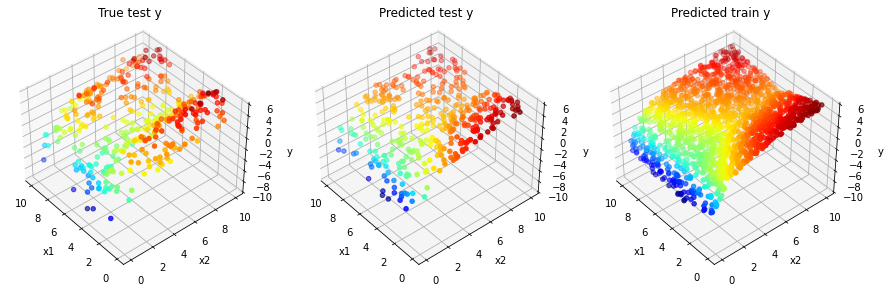

3000 tensor(1.7401, grad_fn=<MseLossBackward0>)


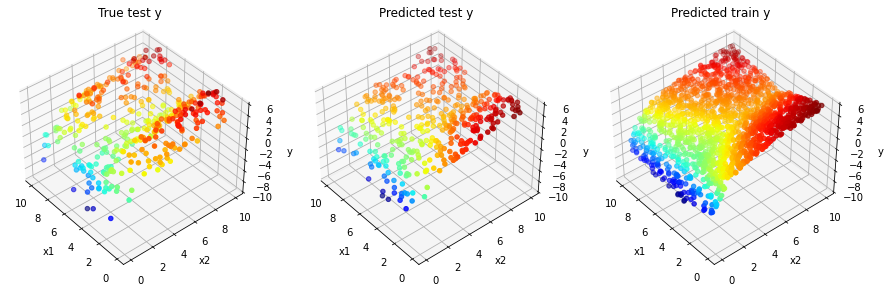

3200 tensor(1.6938, grad_fn=<MseLossBackward0>)


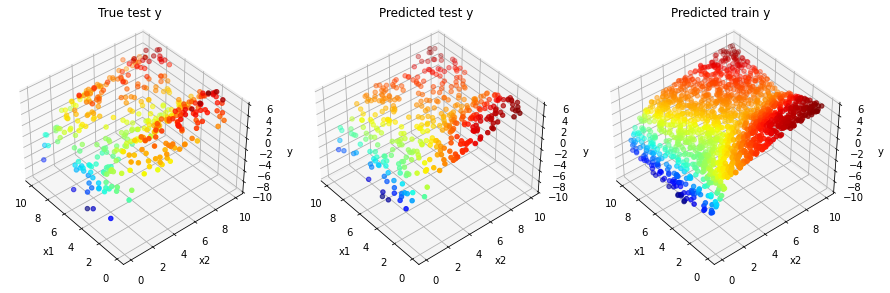

3400 tensor(1.6499, grad_fn=<MseLossBackward0>)


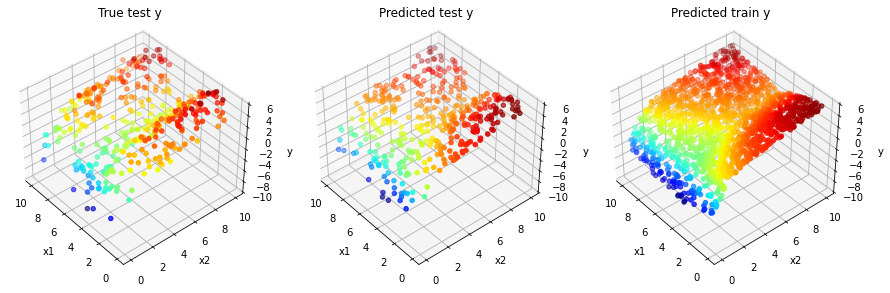

3600 tensor(1.5995, grad_fn=<MseLossBackward0>)


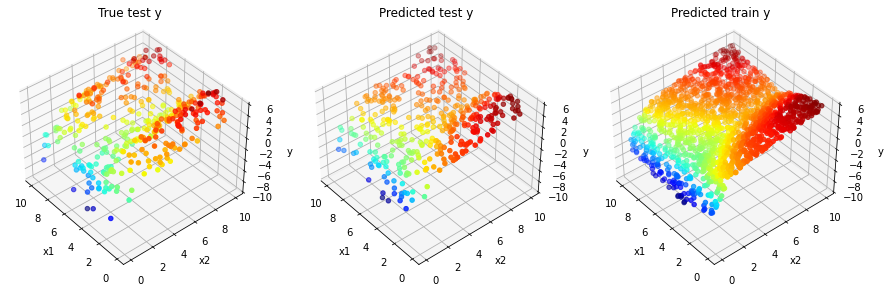

3800 tensor(1.5540, grad_fn=<MseLossBackward0>)


In [26]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

model = MLPModel()
#model = LinearModel()
#print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)
# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수
for i in range(epoch):
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅, 향후 모델을 평가할 때는 eval() 모드 전환 필요
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
                          # 학습을 반복하면서 잔여 그레디언트가 계속 쌓일수도 있기 때문이라 함
    #torch에서 사용하기 위해서는 타입을 torch.tensor로 바꾸어 주어야 한다고 함
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    # print(input_x.shape, true_y.shape, pred_y.shape)
    
    loss = reg_loss(pred_y.squeeze(), true_y) # [[1, 2, 3, 4]] -> [1, 2, 3, 4], 차원이 1인 공간을 없애준다.
    loss.backward() # backward()를 통해서 그라디언트를 구해줌
    optimizer.step() # step()을 통해서 그라디언트를 바탕으로 파라미터를 업데이트 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

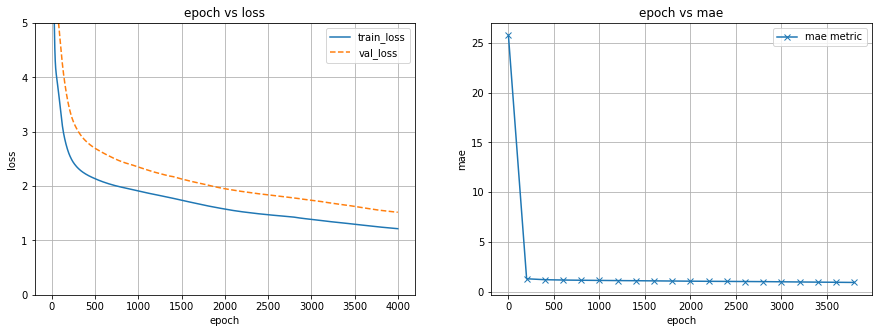

In [27]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()